In [10]:
import numpy as np
import matplotlib.pyplot as plt

from cadet import Cadet
Cadet.cadet_path = 'C:/cadet_from_source/cadet/bin/cadet-cli'
Cadet.cadet_path = '/home/jo/software/cadet/tractor/bin/cadet-cli'

import os
from pathlib import Path
from addict import Dict

In [15]:
def get_2dgrm_unit(params):
    MCTModel = Dict()

    MCTModel.unit_type                = 'MULTI_CHANNEL_TRANSPORT' 
    MCTModel.ncomp                    = params.ncomp
    
    MCTModel.col_length               = params.col_length 
    MCTModel.col_radius               = params.col_radius
    MCTModel.cross_section_area       = np.pi * params.col_radius**2 
    
    MCTModel.col_dispersion           = params.col_dispersion 
    MCTModel.col_porosity             = 1
        
    MCTModel.init_c                   = params.init_c 
    
    # TODO: Figure this out
    # MCTModel.velocity           = params.velocity 
    
    MCTModel.exchange_matrix = params.e
    
    MCTModel.discretization.use_analytic_jacobian = 1 
        
    MCTModel.discretization.schur_safety        = 1.0e-8 
    MCTModel.discretization.weno.boundary_model = 0 
    MCTModel.discretization.weno.weno_eps       = 1e-10
    MCTModel.discretization.weno.weno_order     = 3
    MCTModel.discretization.gs_type             = 1
    MCTModel.discretization.max_krylov          = 0
    MCTModel.discretization.max_restarts        = 10

    MCTModel.discretization.ncol             = params.ncol
    MCTModel.discretization.nrad             = params.nrad

    MCTModel.discretization.radial_disc_type = 'EQUIVOLUME' # Alle Compartments haben gleiches Volumen
    
    return MCTModel


def get_inlet_unit(params):
    InletUnit                     = Dict()
    InletUnit.inlet_type          = 'PIECEWISE_CUBIC_POLY'
    InletUnit.unit_type           = 'INLET'
    InletUnit.ncomp               = params.ncomp
    
    InletUnit.sec_000.const_coeff = params.ncomp * params.c_feed
    InletUnit.sec_001.const_coeff = params.ncomp * [0]

    return InletUnit

def solution_solver_settings(cadet, n_units):
    cadet.root.input.model.nunits = n_units
    
    # Um Speicherplatz zu sparen, kann man hier einstellen, welche 'solutions' gespeichert werden soll. Z.B. in der Chromatographie ist man meistens nur am Ausgangsprofil interessiert und es ist egal, was 'auf der Säule' passeiert. also könnte man 'solution_bulk' ausschalten.
    cadet.root.input['return'].split_components_data = False
    cadet.root.input['return'].split_ports_data = 0
    cadet.root.input['return'].unit_000.write_solution_inlet = 1
    cadet.root.input['return'].unit_000.write_solution_outlet = 1
    cadet.root.input['return'].unit_000.write_solution_bulk = 1
    cadet.root.input['return'].unit_000.write_solution_particle = 1
    cadet.root.input['return'].unit_000.write_solution_solid = 1
    cadet.root.input['return'].unit_000.write_solution_flux = 1
    cadet.root.input['return'].unit_000.write_solution_volume = 1
    cadet.root.input['return'].unit_000.write_coordinates = 1
    cadet.root.input['return'].unit_000.write_sens_outlet = 1
    cadet.root.input['return'].unit_000.write_soldot_bulk = 1

    for unit in range(n_units):
        cadet.root.input['return']['unit_{0:03d}'.format(unit)] = cadet.root.input['return'].unit_000

    # Tolerances for the time integrator
    cadet.root.input.solver.time_integrator.abstol = 1e-8
    cadet.root.input.solver.time_integrator.algtol = 1e-10
    cadet.root.input.solver.time_integrator.reltol = 1e-8
    cadet.root.input.solver.time_integrator.init_step_size = 1e-6
    cadet.root.input.solver.time_integrator.max_steps = 1000000

    # Solver settings
    cadet.root.input.model.solver.gs_type = 1
    cadet.root.input.model.solver.max_krylov = 0
    cadet.root.input.model.solver.max_restarts = 10
    cadet.root.input.model.solver.schur_safety = 1e-8

    # Run the simulation on single thread
    cadet.root.input.solver.nthreads = 1

In [16]:
## Model parameters
ncomp = 1

col_params = Dict()
col_params.ncomp = ncomp
col_params.col_dispersion = 0
col_params.col_radius = 0.01
col_params.col_length = 0.1
col_params.init_c = ncomp*[0]
col_params.ncol = 100
col_params.nrad = 2

k = 40
is_kinetic = True
if is_kinetic:
    f = 1
else:
    f = 1e6

col_params.e = [
    0, f*k,
    f, 0, 
]

inlet_params = Dict()
inlet_params.ncomp = ncomp
inlet_params.c_feed = ncomp*[1]

In [17]:
cadet = Cadet()

#Inlet
cadet.root.input.model.unit_000 = get_inlet_unit(inlet_params)

#Unit
cadet.root.input.model.unit_001 = get_2dgrm_unit(col_params)

# Outlet
cadet.root.input.model.unit_002.unit_type = 'OUTLET'
cadet.root.input.model.unit_002.ncomp = ncomp

#Solutions and Solver Settings
solution_solver_settings(cadet, 3)

#Connections

Q = 1e-6

cadet.root.input.model.connections.nswitches = 1
cadet.root.input.model.connections.connections_include_ports = True
cadet.root.input.model.connections.switch_000.section = 0
cadet.root.input.model.connections.switch_000.connections = [
    0, 1, 0, 0, -1, -1, Q, # unit_000, unit_001, port_0, port_0, all components, all components, Q/ m^3/s
    1, 2, 0, 0, -1, -1, Q, 
]


#Sections
cadet.root.input.solver.sections.nsec = 2
cadet.root.input.solver.sections.section_times = [0,200,1000]
cadet.root.input.solver.user_solution_times = np.linspace(0,1000,450)

### Simulation

In [25]:
#Running simulation
cadet.filename = "./model.h5"
cadet.save()
data=cadet.run()
print(data)
cadet.load()

CompletedProcess(args=['/home/jo/software/cadet/tractor/bin/cadet-cli', './model.h5'], returncode=0, stdout=b'', stderr=b'')


### Plotting Inlet & Outlet

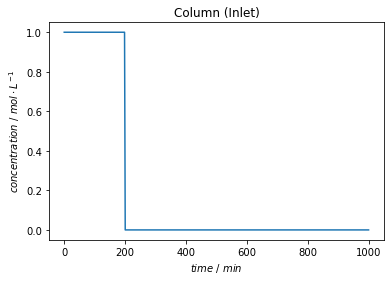

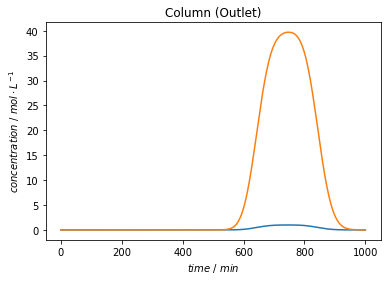

In [26]:
plt.figure()

time = cadet.root.output.solution.solution_times
c = cadet.root.output.solution.unit_000.solution_outlet
plt.plot(time, c)
plt.title('Column (Inlet)')
plt.xlabel('$time~/~min$')
plt.ylabel('$concentration~/~mol \cdot L^{-1} $')
plt.show()



time = cadet.root.output.solution.solution_times
c = cadet.root.output.solution.unit_001.solution_outlet
plt.plot(time, c[:,0,:])
plt.plot(time, c[:,1,:])
plt.title('Column (Outlet)')
plt.xlabel('$time~/~min$')
plt.ylabel('$concentration~/~mol \cdot L^{-1} $')
plt.show()

### Plotting different times

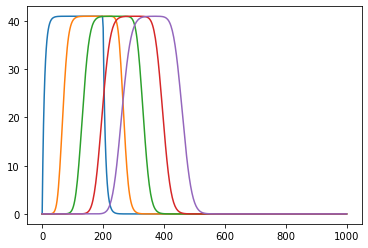

In [28]:
cb = cadet.root.output.solution.unit_001.solution_bulk

plt.plot(time, np.sum(cb[:,:,:,0],axis=2)[:,0])
plt.plot(time, np.sum(cb[:,:,:,0],axis=2)[:,10])
plt.plot(time, np.sum(cb[:,:,:,0],axis=2)[:,20])
plt.plot(time, np.sum(cb[:,:,:,0],axis=2)[:,30])
plt.plot(time, np.sum(cb[:,:,:,0],axis=2)[:,40])

### 2D Plotting

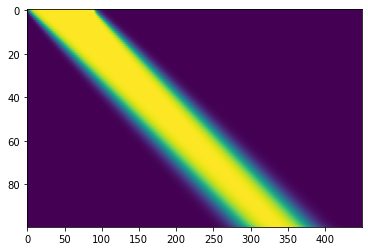

In [29]:
#FIRST compartment

plt.imshow(cb[:,:,0,0].T, cmap='viridis',aspect='auto')
plt.show()

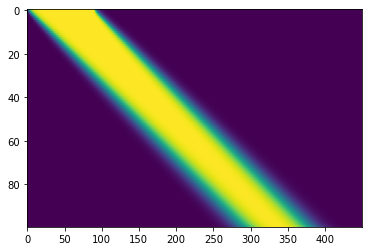

In [30]:
#SECOND compartment

plt.imshow(cb[:,:,1,0].T, cmap='viridis',aspect='auto')
plt.show()

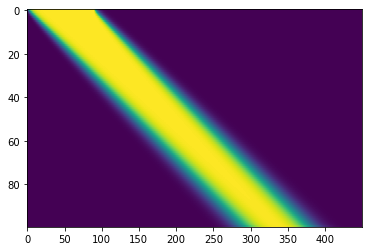

In [31]:
#All compartments

plt.imshow(np.sum(cb[:,:,:,0],axis=2).T, cmap='viridis',aspect='auto')
plt.show()